In [1]:
train_batch_size = 16
num_epochs = 4

In [2]:
from datasets import load_dataset
dataset = load_dataset("stsb_multi_mt", name="en")

Reusing dataset stsb_multi_mt (/home/cs-folq1/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/bc6de0eaa8d97c28a4c22a07e851b05879ae62c60b0b69dd6b331339e8020f07)


In [3]:
from sentence_transformers import models, SentenceTransformer, CrossEncoder

def init_model_sbert():
    model_name = 'bert-base-uncased'
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(
        word_embedding_model.get_word_embedding_dimension(),
        pooling_mode='mean')
    return SentenceTransformer(modules=[word_embedding_model, pooling_model])

def init_model_crossbert():
    model_name = 'bert-base-uncased'
    return CrossEncoder(model_name, num_labels=1)

In [4]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
import numpy as np
from numpy.random import Generator, PCG64


def create_input_examples(dataset_split, num_samples=None, seed=42):
    if num_samples is not None:
        selection = Generator(PCG64(seed)).permutation(
            len(dataset_split))[: num_samples]
    else:
        selection = np.arange(len(dataset_split))

    return [InputExample(texts=[example[1]['sentence1'],
                                example[1]['sentence2']],
                         label=example[1]['similarity_score'] / 5.0)
            for example in
            dataset_split.select(selection).to_pandas().iterrows()]


dev_examples = create_input_examples(dataset['dev'])
test_examples = create_input_examples(dataset['test'])


In [5]:
import torch
from sentence_transformers import losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.cross_encoder.evaluation import \
    CECorrelationEvaluator

def eval_callback(score, epoch, steps):
    print('Epoch {}, score {:.4f}'.format(epoch + 1, score))

def run_experiment_sbert(train_examples):
    model = init_model_sbert()
    train_loss = losses.CosineSimilarityLoss(model=model)
    train_dataloader = DataLoader(train_examples, shuffle=True,
                                  batch_size=train_batch_size)
    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_examples)
    print('sBERT (train size: {})'.format(train_size))
    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=num_epochs, scheduler='ConstantLR',
              optimizer_params={'lr': 2e-5}, evaluator=evaluator,
              callback=eval_callback)
    test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
        test_examples)
    return test_evaluator(model)

def run_experiment_crossbert(train_examples):
    model = init_model_crossbert()
    train_dataloader = DataLoader(train_examples, shuffle=True,
                                  batch_size=train_batch_size)
    evaluator = CECorrelationEvaluator.from_input_examples(dev_examples)
    print('CrossBERT (train size: {})'.format(train_size))
    model.fit(train_dataloader=train_dataloader, loss_fct=torch.nn.MSELoss(),
              epochs=num_epochs, scheduler='ConstantLR',
              optimizer_params={'lr': 1e-5}, evaluator=evaluator,
              callback=eval_callback)
    test_evaluator = CECorrelationEvaluator.from_input_examples(test_examples)
    return test_evaluator(model)




In [7]:
train_sizes = [500, 1000, 1500, 2000, 3000, 4000, None]
results_sbert = []
results_crossbert = []
for train_size in train_sizes:
    train_examples = create_input_examples(dataset['train'],
                                           num_samples=train_size, seed=0)
    sbert_result = run_experiment_sbert(train_examples)
    print('Test score: {:.4f}'.format(sbert_result))
    results_sbert.append(sbert_result)
    print(results_sbert)
    crossbert_result = run_experiment_crossbert(train_examples)
    print('Test score: {:.4f}'.format(crossbert_result))
    results_crossbert.append(crossbert_result)
    print(results_crossbert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: 500)



Epoch 1, score 0.7730



Epoch 2, score 0.7949



Epoch 3, score 0.7942



Epoch 4, score 0.8050

Test score: 0.7363
[0.7363427104713304]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: 500)



Epoch 1, score 0.4798



Epoch 2, score 0.7742



Epoch 3, score 0.8022



Epoch 4, score 0.7986

Test score: 0.6703
[0.6703030605145833]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: 1000)



Epoch 1, score 0.7990



Epoch 2, score 0.8179



Epoch 3, score 0.8209



Epoch 4, score 0.8231

Test score: 0.7652
[0.7363427104713304, 0.7652184041287371]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: 1000)



Epoch 1, score 0.7837



Epoch 2, score 0.8269



Epoch 3, score 0.8291



Epoch 4, score 0.8396

Test score: 0.7252
[0.6703030605145833, 0.7252188160525074]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: 1500)



Epoch 1, score 0.8141



Epoch 2, score 0.8326



Epoch 3, score 0.8366



Epoch 4, score 0.8359

Test score: 0.7810
[0.7363427104713304, 0.7652184041287371, 0.7810429276977439]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: 1500)



Epoch 1, score 0.8071



Epoch 2, score 0.8531



Epoch 3, score 0.8490



Epoch 4, score 0.8572

Test score: 0.7841
[0.6703030605145833, 0.7252188160525074, 0.7841388344774852]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: 2000)



Epoch 1, score 0.8257



Epoch 2, score 0.8356



Epoch 3, score 0.8404



Epoch 4, score 0.8394

Test score: 0.7946
[0.7363427104713304, 0.7652184041287371, 0.7810429276977439, 0.7946197923266162]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: 2000)



Epoch 1, score 0.8281



Epoch 2, score 0.8562



Epoch 3, score 0.8633



Epoch 4, score 0.8697

Test score: 0.7707
[0.6703030605145833, 0.7252188160525074, 0.7841388344774852, 0.7707395023121957]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: 3000)



Epoch 1, score 0.8502



Epoch 2, score 0.8560



Epoch 3, score 0.8598



Epoch 4, score 0.8605

Test score: 0.8263
[0.7363427104713304, 0.7652184041287371, 0.7810429276977439, 0.7946197923266162, 0.8263393430689028]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: 3000)



Epoch 1, score 0.8566



Epoch 2, score 0.8703



Epoch 3, score 0.8697



Epoch 4, score 0.8760

Test score: 0.7956
[0.6703030605145833, 0.7252188160525074, 0.7841388344774852, 0.7707395023121957, 0.7955880617172635]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: 4000)



Epoch 1, score 0.8528



Epoch 2, score 0.8582



Epoch 3, score 0.8615



Epoch 4, score 0.8612

Test score: 0.8350
[0.7363427104713304, 0.7652184041287371, 0.7810429276977439, 0.7946197923266162, 0.8263393430689028, 0.8349598207622135]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: 4000)



Epoch 1, score 0.8446



Epoch 2, score 0.8654



Epoch 3, score 0.8716



Epoch 4, score 0.8727

Test score: 0.8224
[0.6703030605145833, 0.7252188160525074, 0.7841388344774852, 0.7707395023121957, 0.7955880617172635, 0.8223938285019841]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sBERT (train size: None)



Epoch 1, score 0.8674



Epoch 2, score 0.8716



Epoch 3, score 0.8708



Epoch 4, score 0.8720

Test score: 0.8402
[0.7363427104713304, 0.7652184041287371, 0.7810429276977439, 0.7946197923266162, 0.8263393430689028, 0.8349598207622135, 0.8401644704220391]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CrossBERT (train size: None)



Epoch 1, score 0.8659



Epoch 2, score 0.8854



Epoch 3, score 0.8839



Epoch 4, score 0.8891

Test score: 0.8307
[0.6703030605145833, 0.7252188160525074, 0.7841388344774852, 0.7707395023121957, 0.7955880617172635, 0.8223938285019841, 0.8306782971792281]


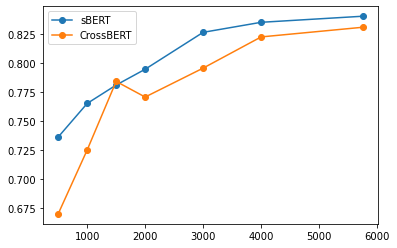

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_sizes[:-1] + [len(dataset['train'])], results_sbert, 'o-',
         label='sBERT')
plt.plot(train_sizes[:-1] + [len(dataset['train'])], results_crossbert, 'o-',
         label='CrossBERT')
plt.legend()